In [ ]:
!nvidia-smi

Fri Jun  2 06:46:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles')
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles


In [ ]:
!pip install transformers
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import gc

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, ConfusionMatrix, AUROC, Precision, Recall, F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
train_dt = pd.read_csv("Datasets/Splits/Train/news_headlines_usa_label_hyperpartisan_train.csv")
test_dt = pd.read_csv("Datasets/Splits/Test/news_headlines_usa_label_hyperpartisan_test.csv")

In [ ]:
(train_dt.shape, test_dt.shape)

((15791, 5), (6768, 5))

In [ ]:
train_dt.head()

,text,slant,nonpartisan,slight-partisan,hyperpartisan
0,Graham: 'We Ought to Sanction the Hell Out of ...,2,0,0,1
1,"Purdue Pharma, The Maker Of OxyContin, Is Repo...",2,0,0,1
2,Trump Considers Urging Acting AG To Appoint Sp...,2,0,0,1
3,Walmart removes firearms from sales floor in s...,0,1,0,0
4,Trump’s Wildest Coronavirus Claim Yet Gets Ins...,2,0,0,1


In [ ]:
test_dt.head()

,text,slant,nonpartisan,slight-partisan,hyperpartisan
0,Former Navy Seal who killed Osama bin Laden ‘b...,1,0,1,0
1,Workers suffer as U.S. pandemic relief bill st...,2,0,0,1
2,Report: Pfizer Vaccines Take Flight Amidst Reg...,2,0,0,1
3,Medical Tourism Was Booming In Mexican Border ...,2,0,0,1
4,"How Trump plowed through $1 billion, losing ca...",1,0,1,0


In [ ]:
train_dt['slant'].value_counts()

1    5489
2    5330
0    4972
Name: slant, dtype: int64

In [ ]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row['text'],
    truncation = True,
    max_length = 512
  ))
  token_counts.append(token_count)

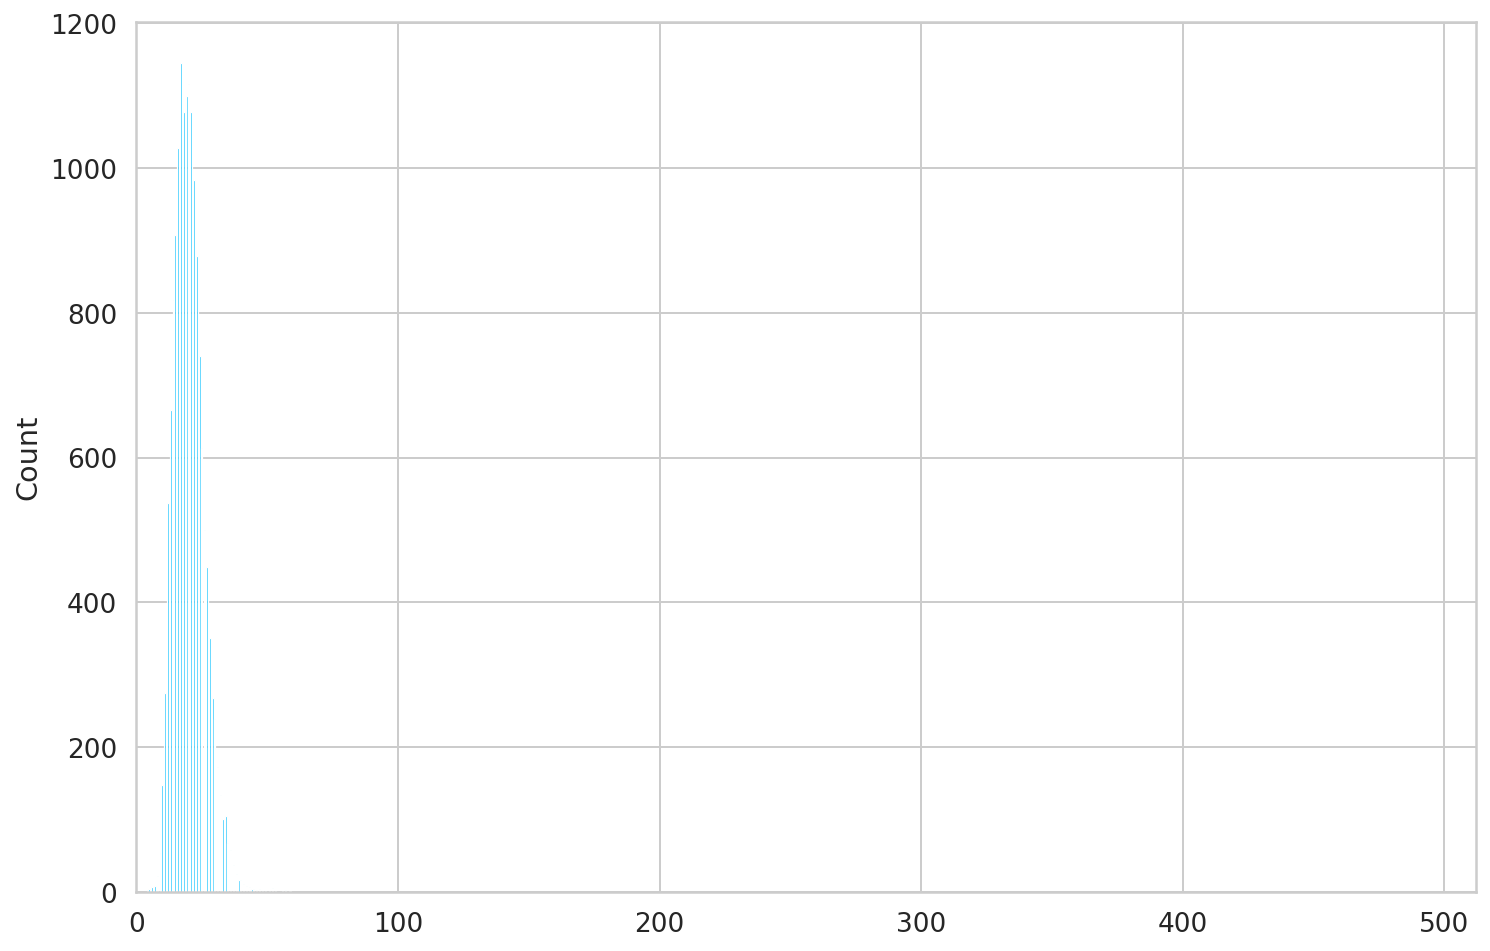

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
max = 0
maxLst = []

for i in token_counts:
  if i > max:
    max = i
    maxLst.append(i)

maxLst
#max_length = 150

[17, 36, 37, 44, 45, 47, 51, 52, 59]

In [ ]:
TEXT = ['text']
CLASSES = ['nonpartisan', 'slight-partisan', 'hyperpartisan']
TARGET = ['slant']
TASK = "multiclass"

In [ ]:
MAX_TOKEN_COUNT = 150

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 16

In [ ]:
class DTset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row[TEXT].astype(str).values.tolist()
    classification = data_row[CLASSES]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      is_split_into_words = True,
      return_attention_mask=True,
      return_tensors='pt'
    )

    return dict(
      text = text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      classification = torch.FloatTensor(classification)
    )

In [ ]:
class DTModule(pl.LightningDataModule):

  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size = 16, max_token_len = 512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = DTset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = DTset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = DTset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
class BertBasedClassifier(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
    self.crossEntropy = nn.CrossEntropyLoss()
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps

  def forward(self, input_ids, attention_mask, classification=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.out(output.pooler_output)
    output = self.softmax(output)
    loss = 0
    if classification is not None:
        loss = self.crossEntropy(output, classification)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return {"loss": loss, "predictions": outputs, "classification": classification}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    classification = batch["classification"]
    loss, outputs = self(input_ids, attention_mask, classification)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    gc.collect()
    return loss

  def train_epoch_end(self, outputs):
    predictions = []
    classification = []
    target = []
    for output in outputs:
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
      for out_class in output["classification"].detach().cpu():
        classification.append(out_class)
    predictions = torch.stack(predictions)
    classification = torch.stack(classification).int()
    for c in classification:
      if c[0] == 1:
        target.append(0)
      if c[1] == 1:
        target.append(1)
      if c[2] == 1:
        target.append(2)
    predictions = torch.from_numpy(np.array(predictions))
    target = torch.from_numpy(np.array(target))
    multiclass_auroc = AUROC(task = TASK, num_classes = len(CLASSES))
    auroc = multiclass_auroc(predictions, target)
    self.logger.experiment.add_scalar(f"multiclass_roc_auc/Train", auroc, self.current_epoch)
    gc.collect()

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

# Fine-tune + Train/Test Evaluation

In [ ]:
(train_dt.shape, test_dt.shape)

((15791, 5), (6768, 5))

In [ ]:
data_module = DTModule(
  train_dt,
  test_dt,
  test_dt,
  tokenizer,
  batch_size = BATCH_SIZE,
  max_token_len = MAX_TOKEN_COUNT
)

In [ ]:
steps_per_epoch=len(train_dt) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(591, 2958)

In [ ]:
model = BertBasedClassifier(
  n_classes= len(CLASSES),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

BertBasedClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
logger = TensorBoardLogger("Lightning_logs", name="Lexicon-of-Sentences-News-Headlines-USA-logs")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 2)

checkpoint_callback = ModelCheckpoint(
  dirpath="Best_model/Lexicon_of_Sentences_News_Headlines_USA",
  filename="Lexicon-of-Sentences-News-Headlines-USA-Best-Checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  accelerator="gpu"
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | bert         | BertModel        | 108 M 
1 | out          | Linear           | 2.3 K 
2 | softmax      | Softmax          | 0     
3 | crossEntropy | CrossEntropyLoss | 0     
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.250   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 987: 'val_loss' reached 0.76112 (best 0.76112), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_News_Headlines_USA/Lexicon-of-Sentences-News-Headlines-USA-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1974: 'val_loss' reached 0.74761 (best 0.74761), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_News_Headlines_USA/Lexicon-of-Sentences-News-Headlines-USA-Best-Checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2961: 'val_loss' reached 0.73230 (best 0.73230), saving model to '/content/drive/MyDrive/Colab Notebooks/Media_Bias_Feature_for_the_Identification_of_Biased_Statements_in_News_Articles/Best_model/Lexicon_of_Sentences_News_Headlines_USA/Lexicon-of-Sentences-News-Headlines-USA-Best-Checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
del model
gc.collect()

0

In [ ]:
trained_model = BertBasedClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(CLASSES)
)

'''
#Load from DIR
trained_model = BertBasedClassifier.load_from_checkpoint(
  "Best_model/Lexicon_of_Sentences_News_Headlines_USA/Lexicon-of-Sentences-News-Headlines-USA-Best-Checkpoint.ckpt",
  n_classes=len(CLASSES)
)
'''

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'\n#Load from DIR\ntrained_model = BertBasedClassifier.load_from_checkpoint(\n  "Best_model/Lexicon_of_Sentences_News_Headlines_USA/Lexicon-of-Sentences-News-Headlines-USA-Best-Checkpoint.ckpt",\n  n_classes=len(CLASSES)\n)\n'

In [ ]:
trained_model.bert.save_pretrained("Checkpoints/bert-hyperpartisan-statement-headline-pretrained")

In [ ]:
trained_model.eval()
trained_model.freeze()

In [ ]:
trainer.test(trained_model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.732303261756897     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.732303261756897}]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = DTset(
  test_dt,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
classification = []
target = []

for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  classification.append(item["classification"].int())

for c in classification:
      if c[0] == 1:
        target.append(0)
      if c[1] == 1:
        target.append(1)
      if c[2] == 1:
        target.append(2)

predictions = torch.stack(predictions).detach().cpu()
classification = torch.stack(classification).detach().cpu()
target = torch.from_numpy(np.array(target))

  0%|          | 0/6768 [00:00<?, ?it/s]

In [ ]:
predictions

tensor([[4.2009e-04, 9.9844e-01, 1.1369e-03],
        [9.9959e-01, 2.9107e-04, 1.2101e-04],
        [5.8233e-05, 3.6726e-05, 9.9990e-01],
        ...,
        [9.9968e-01, 1.9041e-04, 1.3065e-04],
        [9.9975e-01, 1.5374e-04, 9.1249e-05],
        [9.9970e-01, 1.9851e-04, 9.9672e-05]])

In [ ]:
classification

tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]], dtype=torch.int32)

In [ ]:
target

tensor([1, 2, 2,  ..., 0, 0, 0])

In [ ]:
confusionMatrix = ConfusionMatrix(task = TASK, num_classes = len(CLASSES))
confusionMatrix(predictions, target)

tensor([[1571,  523,   32],
        [ 392, 1781,  180],
        [  40,   96, 2153]])

In [ ]:
accuracy = Accuracy(task = TASK, num_classes = len(CLASSES), average = "macro", top_k=1)
print("Accuracy (macro):", accuracy(predictions, target).item())

Accuracy (macro): 0.8121459484100342


In [ ]:
precision = Precision(task = TASK, num_classes = len(CLASSES), average = "macro", top_k=1)
recall = Recall(task = TASK, num_classes = len(CLASSES), average = "macro", top_k=1)
f1Macro = F1Score(task = TASK, num_classes = len(CLASSES), average = "macro", top_k=1)
print("Percision (macro):", precision(predictions, target).item(), "\nRecall (macro):", recall(predictions, target).item(), "\nF1 Score(Macro):", f1Macro(predictions, target).item())

Percision (macro): 0.8122553825378418 
Recall (macro): 0.8121459484100342 
F1 Score(Macro): 0.8118686676025391


In [ ]:
auroc = AUROC(task = TASK, num_classes = len(CLASSES), average = "macro")
print("AUROC (macro):", auroc(predictions, target).item())

AUROC (macro): 0.9212958216667175
